# Compact model of double-gated MOSFET



Compact model was built for the double-gate MOSFET based on [1] and tested

---

## Tick formatting

---

In [25]:
def y_fmt(y, pos):
    decades = [1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15]
    suffix  = ["G", "M", "k", "" , "mA" , "$\mu$A", 'nA', 'pA', 'fA']
    if y == 0:
        return str(0)
    for i, d in enumerate(decades):
        if np.abs(y) >= d:
            val = y / float(d)
            # Limiting the number of decimal places to 2
            val_str = "{:.2f}".format(val)
            # Remove trailing zeros if any
            return f"{val_str} {suffix[i]}"
    return y

## Necessary Libraries

---

In [26]:
import scipy
import numpy as np
import pandas as pd
import scipy.constants

import time

import sympy
import sympy.solvers.solvers

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter 
plt.rcParams["figure.figsize"] = (10, 7.5)

import bisection

## Constants and Parameter

---

In [27]:
# Physical constants
eps_0       = 8.854e-14                             # Free space permittivity
eps_Si      = eps_0 * 11.68                         # Silicon permittivity
eps_SiO2    = eps_0 * 3.9                           # SiO2 permittivity
phi_t       = 0.0259                                # Thermal voltage
q           = scipy.constants.electron_volt         # Charge of an electron in quolombs
mu_n        = 300                                   # Electron mobility in silicon

# Device parameters
ni          = 1e10                                  # Intrinsic carrier concentration
t_ox        = 1.25e-7                                # Oxide thickness (cm)
t_si        = 5e-7                                  # Thickness of the channel (cm)
l_ch        = 1e-4                                  # Channel length (cm)
w_ch        = 1e-4                                  # Channel width
vfb         = 0                                     # Flat band voltage (V)

## Current Modelling

---

In [28]:
def g_r(beta):
    r = (eps_Si * t_ox) / (eps_SiO2 * t_si)    
    return beta * np.tan(beta) - np.square(beta) / 2 + r * np.square(beta) * np.square(np.tan(beta))

def f_r(beta):
    r = (eps_Si * t_ox) / (eps_SiO2 * t_si)
    return np.log(beta) - np.log(np.cos(beta)) + 2 * r * beta * np.tan(beta)

def get_current(vgb, vds, vfb, err = 1e-3):
    v0 = vfb + 2 * phi_t * np.log( 2 * np.sqrt((2 * eps_Si * phi_t) / (q * ni)) / t_si)
    beta_s, hist_s = bisection.bisection(lambda x : f_r(x) - (vgb - v0) / (2 * phi_t),       0, np.pi / 2, err)
    beta_d, hist_d = bisection.bisection(lambda x : f_r(x) - (vgb - v0 - vds) / (2 * phi_t), 0, np.pi / 2, err)
    return mu_n * (w_ch / l_ch) * (4 * eps_Si / t_si) * np.square(2 * phi_t) * (g_r(beta_s) - g_r(beta_d))

---
## Testing the models

The models are run and the outputs are compared with characteristics extracted from the reference paper [1].

In [29]:
df_idvd = pd.read_csv("wpd_datasets_IdVd.csv")
df_idvg_log = pd.read_csv("wpd_datasets_IdVg.csv")
df_idvg = pd.read_csv("IdVg.csv")

In [30]:
df_idvd.head(10)

,vg_2v x,vg_2v y,vg_1.5v x,vg_1.5v y,vg_1v x,vg_1v y,vg_0.5v x,vg_0.5v y
0,0.031597,0.000064,0.015879,0.000019,0.020386,0.000016,0.027080,0.000002
1,0.000355,0.000009,0.062953,0.000075,0.075976,0.000039,0.075472,0.000002
2,0.062953,0.000116,0.110527,0.000124,0.130558,0.000064,0.130558,0.000002
3,0.093000,0.000168,0.158101,0.000174,0.185644,0.000083,0.185644,0.000002
4,0.123046,0.000220,0.210683,0.000223,0.240730,0.000099,0.240730,0.000003
5,0.153093,0.000270,0.265769,0.000272,0.295816,0.000112,0.295816,0.000002
6,0.183140,0.000318,0.320855,0.000316,0.350902,0.000123,0.350902,0.000002
7,0.213187,0.000365,0.375941,0.000357,0.405987,0.000129,0.405987,0.000002
8,0.245738,0.000416,0.431026,0.000395,0.461073,0.000134,0.461073,0.000002
9,0.280792,0.000467,0.486112,0.000430,0.516159,0.000135,0.516159,0.000004


C:\Users\manis\AppData\Local\Temp\ipykernel_17988\816168632.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(beta) - np.log(np.cos(beta)) + 2 * r * beta * np.tan(beta)


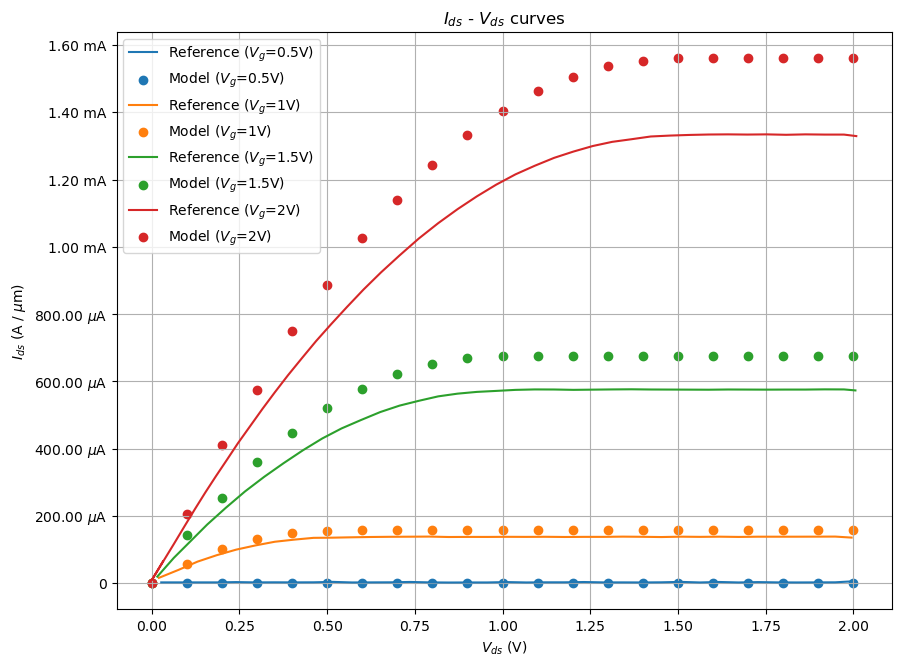

In [31]:
vg_inp = np.linspace(0, 2, 21)
vd_inp = np.linspace(0, 2, 21)
id     = {}

vg_disp = [0.5, 1, 1.5, 2]
vd_disp = [1]

for vg in vg_inp:
    out     = np.asarray([get_current(vg, x, 0) for x in vd_inp])
    id[vg]  = out

for vg in vg_disp:
    plt.plot(df_idvd[f"vg_{vg}v x"],    df_idvd[f"vg_{vg}v y"],     label=f"Reference ($V_g$={vg}V)")
    plt.scatter(vd_inp,                 id[vg], marker='o',         label=f"Model ($V_g$={vg}V)")

plt.title("$I_{ds}$ - $V_{ds}$ curves")
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A / $\mu$m)")
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_fmt))  # Used for units

plt.legend()
plt.grid()
plt.show()

C:\Users\manis\AppData\Local\Temp\ipykernel_17988\816168632.py:7: RuntimeWarning: divide by zero encountered in log
  return np.log(beta) - np.log(np.cos(beta)) + 2 * r * beta * np.tan(beta)
C:\Users\manis\AppData\Local\Temp\ipykernel_17988\3800155620.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


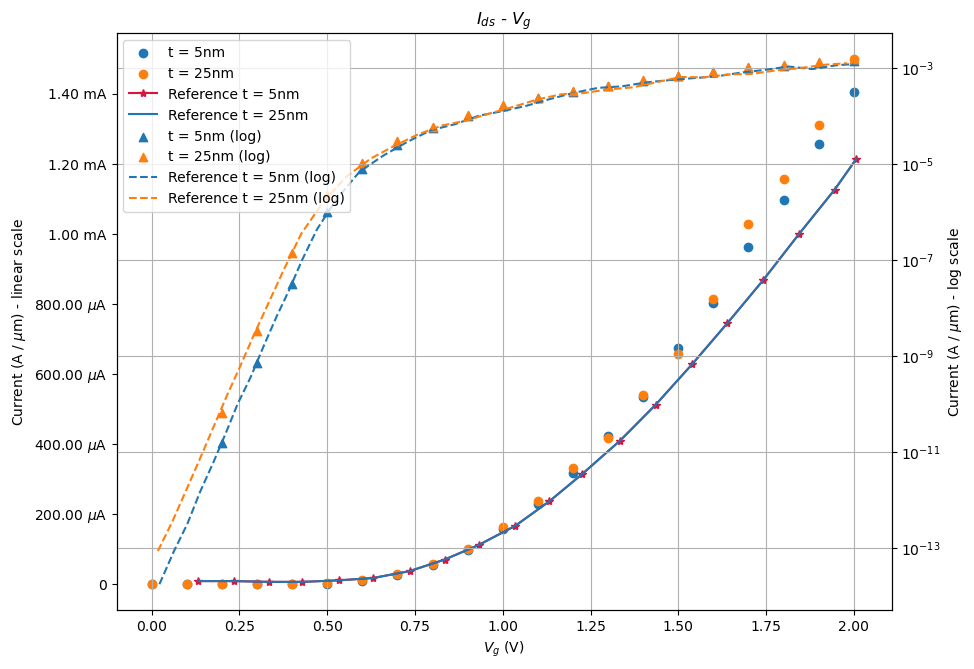

In [32]:
t_inp   = [5e-7, 25e-7]
vd      = 1

fig = plt.figure()
ax1 = fig.add_subplot()
ax2 = ax1.twinx()

id = []

for t in t_inp:
    t_si    = t
    out     = np.asarray([get_current(x, vd, 0) for x in vg_inp])
    ax1.scatter(vg_inp, out, label=f"t = {int(t*1e7)}nm")
    ax2.scatter(vg_inp, out, label=f"t = {int(t*1e7)}nm (log)",    marker='^')

    id.append(out)
    
ax1.plot(df_idvg["5nm x"], df_idvg["5nm y"]*1e-3,   label=f"Reference t = 5nm", color = 'crimson', marker ='*')
ax1.plot(df_idvg["25nm x"],df_idvg["25nm y"]*1e-3,  label=f"Reference t = 25nm")

ax2.plot(df_idvg_log["5nm x"], df_idvg_log["5nm y"]*1e-3,   label=f"Reference t = 5nm (log)",   linestyle='--')
ax2.plot(df_idvg_log["25nm x"],df_idvg_log["25nm y"]*1e-3,  label=f"Reference t = 25nm (log)",  linestyle='--')

ax1.set_title("$I_{ds}$ - $V_g$")
ax2.set_yscale('log')

ax1.set_xlabel("$V_g$ (V)")
ax1.set_ylabel("Current (A / $\mu$m) - linear scale")
ax1.yaxis.set_major_formatter(FuncFormatter(y_fmt))     #Used for units
ax2.set_ylabel("Current (A / $\mu$m) - log scale")

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)
ax1.grid(axis='x')
ax2.grid(axis='y')
fig.show()

---
# References

[1] **"A Continuous, Analytic Drain-Current Model for DG MOSFETs"** - *Yuan Taur at.al*, IEEE ELECTRON DEVICE LETTERS, VOL. 25, NO. 2, FEBRUARY 2004